In [55]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

import random

In [56]:
mat_df = pd.read_csv("student-mat.csv")
por_df = pd.read_csv("student-por.csv")

# add ID 
mat_df["ID_m"] = list(range(1, len(mat_df) + 1))
por_df["ID_p"] = list(range(1, len(por_df) + 1))

# completely join both dataframes together
outer = mat_df.merge(por_df, how = "outer", on = ["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"], indicator=True)

# subset to students who only have math grades
math_only_temp = outer[(outer._merge== "left_only")].drop("_merge", axis=1)

# subset to students who only have portugese grades
por_only_temp = outer[(outer._merge == "right_only")].drop("_merge", axis = 1)

both_temp = outer[(outer._merge == "both")].drop("_merge", axis = 1)

random.seed(37)

# assign 0 or 1 to each student
both_temp["rand"] = [int(random.random() >.5) for i in range(0, len(both_temp))]

# if they are assigned 1, collect their math ID
rand_math_ID = list(both_temp[(both_temp["rand"] == 1)]["ID_m"])

# if assigned 0, collect their portugese ID
rand_por_ID = list(both_temp[(both_temp["rand"] == 0)]["ID_p"])

# create a new column to identify subject students grade is for
mat_df["Subject"] = "Math"
por_df["Subject"] = "Portugese"

# get ID's of those only enrolled in math
math_only_ID = list(math_only_temp["ID_m"])
# concat all the ID's of math students
all_math_ID = math_only_ID + rand_math_ID

# get ID's of those only enrolled in portugese
por_only_ID = list(por_only_temp["ID_p"])
# concat all the ID's of the portugese students
all_por_ID = por_only_ID + rand_por_ID

# get the dataframes with all the selected IDs
por_only_df = por_df[por_df["ID_p"].isin(all_por_ID)]
mat_only_df = mat_df[mat_df["ID_m"].isin(all_math_ID)]

complete_df = pd.concat([por_only_df, mat_only_df])

In [57]:
complete_df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1,G2,G3,ID_p,Subject,ID_m
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,1,1,3,2,9,11,11,2.0,Portugese,NaN
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,1,1,1,2,10,13,13,8.0,Portugese,NaN
9,GP,M,15,U,GT3,T,3,4,other,other,...,1,1,5,0,12,12,13,10.0,Portugese,NaN
12,GP,M,15,U,LE3,T,4,4,health,services,...,1,3,5,0,12,13,12,13.0,Portugese,NaN
13,GP,M,15,U,GT3,T,4,3,teacher,other,...,1,2,3,0,12,12,13,14.0,Portugese,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,MS,F,18,U,LE3,T,3,1,teacher,services,...,1,1,1,0,7,9,8,NaN,Math,389.0
389,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,5,0,6,5,0,NaN,Math,390.0
390,MS,M,20,U,LE3,A,2,2,services,services,...,4,5,4,11,9,9,9,NaN,Math,391.0
392,MS,M,21,R,GT3,T,1,1,other,other,...,3,3,3,3,10,8,7,NaN,Math,393.0


In [58]:
complete_df.schoolsup = complete_df.schoolsup.eq('yes').mul(1)
complete_df.famsup = complete_df.famsup.eq('yes').mul(1)
complete_df.nursery = complete_df.nursery.eq('yes').mul(1)
complete_df.higher = complete_df.higher.eq('yes').mul(1)

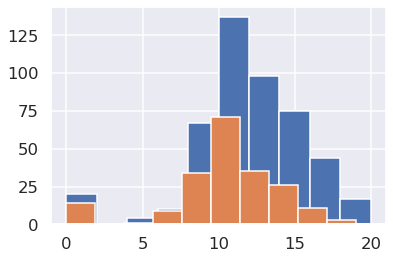

In [59]:
complete_df.groupby('address').get_group('U')['G3'].hist()
complete_df.groupby('address').get_group('R')['G3'].hist()

f1 = plt.gcf()

In [60]:
# Address Ratios
complete_addr = complete_df['address'].value_counts()

complete_addr_values = pd.Series([complete_addr[0], complete_addr[1]])

chisq, p_val_chi = stats.chisquare(complete_addr_values, axis=None)

if p_val_chi < 0.01:
    print('There is a significant difference in ratios!')

There is a significant difference in ratios!


In [84]:
# Urban vs. Rural OLS Regression Results
outcome_addr, predictors_addr = patsy.dmatrices('G3 ~ address', data = complete_df)

mod_addr = sm.OLS(outcome_addr, predictors_addr)
res_addr = mod_addr.fit()
print(res_addr.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     10.02
Date:                Mon, 04 Mar 2024   Prob (F-statistic):            0.00162
Time:                        22:43:48   Log-Likelihood:                -1854.1
No. Observations:                 676   AIC:                             3712.
Df Residuals:                     674   BIC:                             3721.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.5294      0.263     39.964   

In [63]:
# Support vs. No Support OLS Regression Results
complete_df = complete_df.assign(all_sup = complete_df['schoolsup'] + complete_df['famsup'])

In [68]:
outcome_sup, predictors_sup = patsy.dmatrices('G3 ~ C(all_sup)', data = complete_df)

mod_sup = sm.OLS(outcome_sup, predictors_sup)
res_sup = mod_sup.fit()
print(res_sup.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.146
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.319
Time:                        22:33:12   Log-Likelihood:                -1857.9
No. Observations:                 676   AIC:                             3722.
Df Residuals:                     673   BIC:                             3735.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.1789      0.241     

In [69]:
# Higher Education vs. No Intent/Activity OLS Regression Results
complete_df = complete_df.assign(all_high_ed = complete_df['nursery'] + complete_df['higher'])

In [70]:
outcome_ed, predictors_ed = patsy.dmatrices('G3 ~ C(all_high_ed)', data = complete_df)

mod_ed = sm.OLS(outcome_ed, predictors_ed)
res_ed = mod_ed.fit()
print(res_ed.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     8.806
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           0.000168
Time:                        22:35:23   Log-Likelihood:                -1850.3
No. Observations:                 676   AIC:                             3707.
Df Residuals:                     673   BIC:                             3720.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.9474    

In [71]:
# Total Alcohol Consumption (TAC)
complete_df = complete_df.assign(total_alc = complete_df['Dalc'] + complete_df['Walc'])

In [77]:
# TAC Spectrum OLS Regression Results
outcome_alc, predictors_alc = patsy.dmatrices('G3 ~ C(total_alc)', data = complete_df)

mod_alc = sm.OLS(outcome_alc, predictors_alc)
res_alc = mod_alc.fit()
print(res_alc.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.447
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.173
Time:                        22:42:15   Log-Likelihood:                -1853.2
No. Observations:                 676   AIC:                             3724.
Df Residuals:                     667   BIC:                             3765.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.5336      0

In [91]:
# TAC Spectrum + address OLS Regression Results
outcome_alc_addr, predictors_alc_addr = patsy.dmatrices('G3 ~ C(total_alc) + address', data = complete_df)

mod_alc_addr = sm.OLS(outcome_alc_addr, predictors_alc_addr)
res_alc_addr = mod_alc_addr.fit()
print(res_alc_addr.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.333
Date:                Mon, 04 Mar 2024   Prob (F-statistic):             0.0137
Time:                        22:45:50   Log-Likelihood:                -1848.6
No. Observations:                 676   AIC:                             3717.
Df Residuals:                     666   BIC:                             3762.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             10.8448      0

In [89]:
# TAC Spectrum + all_sup OLS Regression Results
outcome_alc_sup, predictors_alc_sup = patsy.dmatrices('G3 ~ C(total_alc) + C(all_sup)', data = complete_df)

mod_alc_sup = sm.OLS(outcome_alc_sup, predictors_alc_sup)
res_alc_sup = mod_alc_sup.fit()
print(res_alc_sup.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.354
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.198
Time:                        22:45:05   Log-Likelihood:                -1852.2
No. Observations:                 676   AIC:                             3726.
Df Residuals:                     665   BIC:                             3776.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.5589      0

In [94]:
# TAC Spectrum OLS vs high_ed Regression Results
outcome_alc_ed, predictors_alc_ed = patsy.dmatrices('G3 ~ C(total_alc) + C(all_high_ed)', data = complete_df)

mod_alc_ed = sm.OLS(outcome_alc_ed, predictors_alc_ed)
res_alc_ed = mod_alc_ed.fit()
print(res_alc_ed.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.651
Date:                Mon, 04 Mar 2024   Prob (F-statistic):            0.00355
Time:                        22:47:02   Log-Likelihood:                -1845.8
No. Observations:                 676   AIC:                             3714.
Df Residuals:                     665   BIC:                             3763.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.2651    

In [95]:
# TAC Spectrum OLS Regression Results
outcome_alc_all, predictors_alc_all = patsy.dmatrices('G3 ~ C(total_alc) + address + C(all_sup) + C(all_high_ed)', data = complete_df)

mod_alc_all = sm.OLS(outcome_alc_all, predictors_alc_all)
res_alc_all = mod_alc_all.fit()
print(res_alc_all.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.863
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           0.000495
Time:                        22:48:08   Log-Likelihood:                -1840.6
No. Observations:                 676   AIC:                             3709.
Df Residuals:                     662   BIC:                             3772.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.6999    